In [64]:
# Data wrangling
import pandas as pd 

# Visualization
import matplotlib.pyplot as plt

# Date wrangling
import datetime

# Math operations
import numpy as np

# Random sampling
import random

# Keras API 
from tensorflow import keras

# Deep learning 
from keras.models import Input, Model, Sequential
from keras.layers import Dense, Dropout, LSTM, Concatenate, SimpleRNN, Masking, Flatten
from keras import losses
from keras.callbacks import EarlyStopping
from keras.initializers import RandomNormal

In [65]:
def create_X_Y(ts: np.array, lag=1, n_ahead=1, target_index=0) -> tuple:
    """
    A method to create X and Y matrix from a time series array for the training of 
    deep learning models 
    """
    # Extracting the number of features that are passed from the array 
    n_features = ts.shape[1]
    
    # Creating placeholder lists
    X, Y = [], []

    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag - n_ahead):
            Y.append(ts[(i + lag):(i + lag + n_ahead), target_index])
            X.append(ts[i:(i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an RNN input shape 
    X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y

In [66]:
class NNMultistepModel():
    
    def __init__(
        self, 
        X, 
        Y, 
        n_outputs,
        n_lag,
        n_ft,
        n_layer,
        batch,
        epochs, 
        lr,
        Xval=None,
        Yval=None,
        mask_value=-999.0,
        min_delta=0.001,
        patience=5
    ):
        lstm_input = Input(shape=(n_lag, n_ft))

        # Series signal 
        lstm_layer = LSTM(n_layer, activation='relu')(lstm_input)

        x = Dense(n_outputs)(lstm_layer)
        
        self.model = Model(inputs=lstm_input, outputs=x)
        self.batch = batch 
        self.epochs = epochs
        self.n_layer=n_layer
        self.lr = lr 
        self.Xval = Xval
        self.Yval = Yval
        self.X = X
        self.Y = Y
        self.mask_value = mask_value
        self.min_delta = min_delta
        self.patience = patience

    def trainCallback(self):
        return EarlyStopping(monitor='loss', patience=self.patience, min_delta=self.min_delta)

    def train(self):
        # Getting the untrained model 
        empty_model = self.model
        
        # Initiating the optimizer
        optimizer = keras.optimizers.Adam(learning_rate=self.lr)

        # Compiling the model
        empty_model.compile(loss=losses.MeanAbsoluteError(), optimizer=optimizer)

        if (self.Xval is not None) & (self.Yval is not None):
            history = empty_model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch, 
                validation_data=(self.Xval, self.Yval), 
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
        else:
            history = empty_model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch,
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
        
        # Saving to original model attribute in the class
        self.model = empty_model
        
        # Returning the training history
        return history
    
    def predict(self, X):
        return self.model.predict(X)

In [67]:
df = pd.read_csv('values_normalized.csv')
df = df.dropna()
ts = df[[
'huss', 
'f107', 
'siconc', 
'kp', 
'ap', 
'iprp', 
'ssn',
'tsi',
'scnum',
'iprm',
'iprg',
'scph',
'tas'
]].values

# Number of lags (hours back) to use for models
lag = 200
# Steps ahead to forecast 
n_ahead = 200
# Share of obs in testing 
test_share = 0.15
# Epochs for training
epochs = 10
# Batch size 
batch_size = 256
# Learning rate
lr = 0.001
# Number of neurons in LSTM layer
n_layer = 50

X, Y = create_X_Y(ts, lag=lag, n_ahead=n_ahead, target_index=12)

n_ft = X.shape[2]

Xtrain, Ytrain = X[0:int(X.shape[0] * (1 - test_share))], Y[0:int(X.shape[0] * (1 - test_share))]
Xval, Yval = X[int(X.shape[0] * (1 - test_share)):], Y[int(X.shape[0] * (1 - test_share)):]

# Creating the model object 
model = NNMultistepModel(
    X=Xtrain,
    Y=Ytrain,
    n_outputs=n_ahead,
    n_lag=lag,
    n_ft=n_ft,
    n_layer=n_layer,
    batch=batch_size,
    epochs=epochs, 
    lr=lr,
    Xval=Xval,
    Yval=Yval,
)
# Training the model 
history = model.train()

Epoch 1/10
68/68 [==============================] - 14s 203ms/step - loss: 0.3044 - val_loss: 0.2176
Epoch 2/10
68/68 [==============================] - 14s 199ms/step - loss: 0.1915 - val_loss: 0.1694
Epoch 3/10
68/68 [==============================] - 13s 197ms/step - loss: 0.1550 - val_loss: 0.1274
Epoch 4/10
68/68 [==============================] - 13s 195ms/step - loss: 0.1418 - val_loss: 0.1166
Epoch 5/10
68/68 [==============================] - 13s 192ms/step - loss: 0.1176 - val_loss: 0.0987
Epoch 6/10
68/68 [==============================] - 13s 198ms/step - loss: 0.0918 - val_loss: 0.0864
Epoch 7/10
68/68 [==============================] - 13s 196ms/step - loss: 0.1009 - val_loss: 0.0877
Epoch 8/10
68/68 [==============================] - 13s 194ms/step - loss: 0.0820 - val_loss: 0.0729
Epoch 9/10
68/68 [==============================] - 13s 197ms/step - loss: 0.0724 - val_loss: 0.0703
Epoch 10/10
68/68 [==============================] - 13s 191ms/step - loss: 0.0677 - val_lo

In [68]:
# Comparing the forecasts with the actual values
yhat = [x[0] for x in model.predict(Xval)]
y = [y[0] for y in Yval]

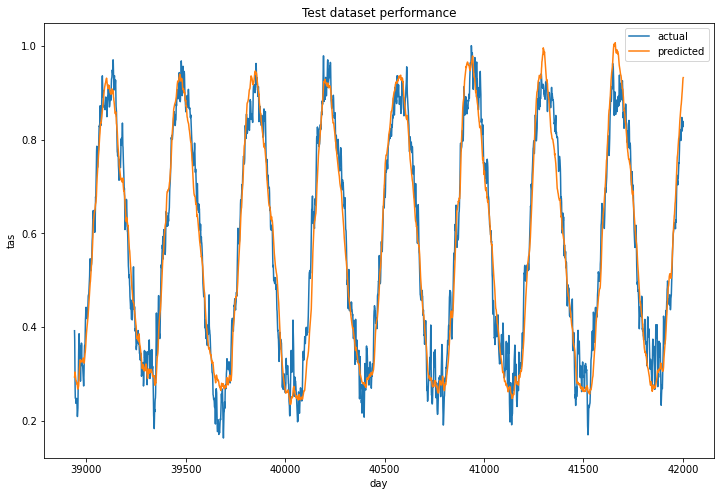

In [69]:
ts_end = df.tail(len(yhat)).copy()
ts_end.reset_index(inplace=True)
plt.figure(figsize=(12, 8))
plt.plot(ts_end["day"], y, label='actual')
plt.plot(ts_end['day'], yhat, label='predicted')
plt.xlabel("day")
plt.ylabel("tas")
plt.title("Test dataset performance")
plt.legend()
plt.show()

In [82]:
# Forecasting on all the samples in the validation set 
forecast = model.predict(Xval)
yhat = forecast[-1]

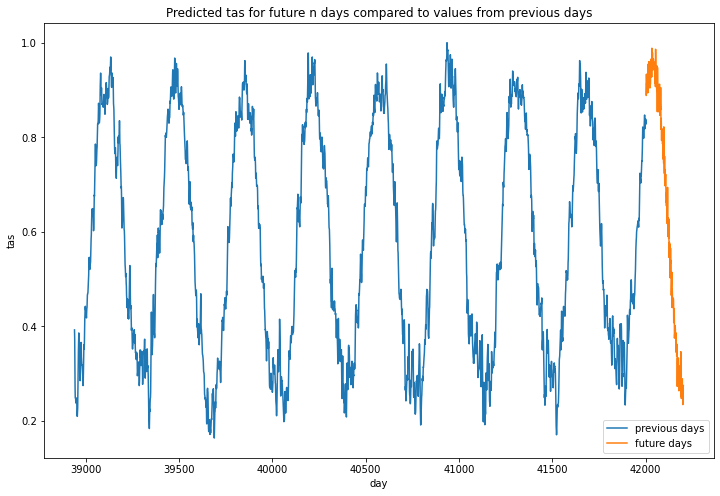

In [83]:
#creating graph with tas values from previous days AND predicted values for future n days
xDay = []
for i in range(1, n_ahead+1):
    xDay.append(42002+i)
plt.figure(figsize=(12, 8))
plt.plot(ts_end["day"], y, label='previous days')
plt.plot(xDay, yhat, label='future days')
# plt.xticks(np.arange(0, len(xDay), step=100))
plt.xlabel("day")
plt.ylabel("tas")
plt.title("Predicted tas for future n days compared to values from previous days")
plt.legend()
plt.show()